# Celltypist Confidence score analyisis

Celltypist is a deep-learning based Cell type prediction model. It takes transcript counts from important genes as input and predicts a cell type as output. Alson gwith the cell type prediction, celltypist provides confidence scores corresponding to the predictions. These can be used to asess the confidence of the mapping as well as to find cell groups where the model struggles.

please use the environment tmp_celltypist (YAML file in environments folder)

Note that this pipeline can be used to run the same analysis on the b2c (or any bin-to-cell) outputs. Just change the cells_adata_path

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc
import celltypist
from celltypist import models

In [ ]:
output_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2"
# Anndata object path
cells_adata_path = f"{output_path}/tmap/weighted_by_area|celltypist_cells_adata.h5"

model_name1 = "Human_Lung_Atlas.pkl"
model_name2 = "Cells_Lung_Airway.pkl"

In [ ]:

adata = sc.read_h5ad(cells_adata_path)


The expression matrix (`adata.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [5]:
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
adata.obs["lib_size"] = lib_size

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/degottardiraphael/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChall

In [9]:
predictions1 = celltypist.annotate(adata, model = model_name1, majority_voting = True)

🔬 Input data has 188596 cells and 18085 genes
🔗 Matching reference genes in the model
🧬 4503 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/misc/ngseq12/miniforge3/envs/tmp_celltypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [15]:
predictions2 = celltypist.annotate(adata, model = model_name2, majority_voting = True)

🔬 Input data has 188596 cells and 18085 genes
🔗 Matching reference genes in the model
🧬 4683 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [10]:
adata = predictions1.to_adata( prefix= 'M1_')

In [16]:
adata = predictions2.to_adata( prefix= 'M2_')

## Results for the  "Human_Lung_Atlas.pkl" model

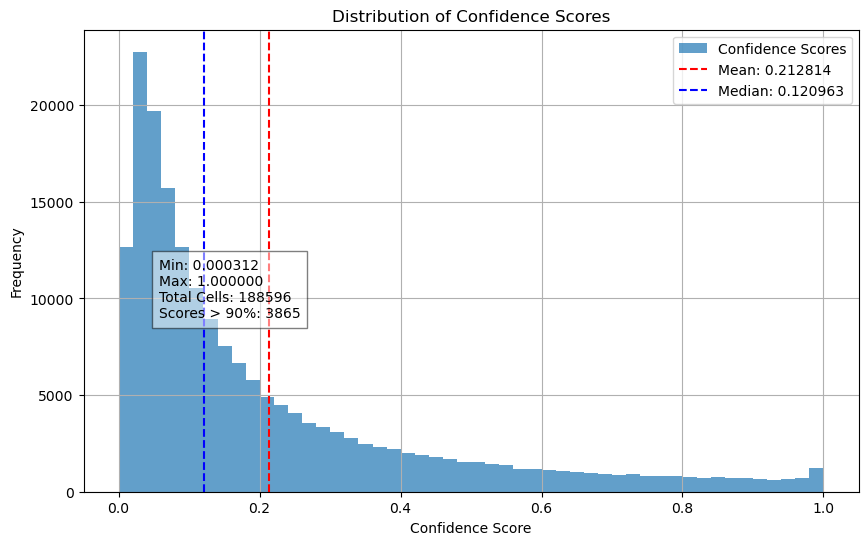

In [ ]:
# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['M1_conf_score'].mean()
median_conf_score = adata.obs['M1_conf_score'].median()
total_cells = adata.obs['M1_conf_score'].shape[0]

# Plot histogram
adata.obs['M1_conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['M1_conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['M1_conf_score'].min():.6f}\n"
    f"Max: {adata.obs['M1_conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

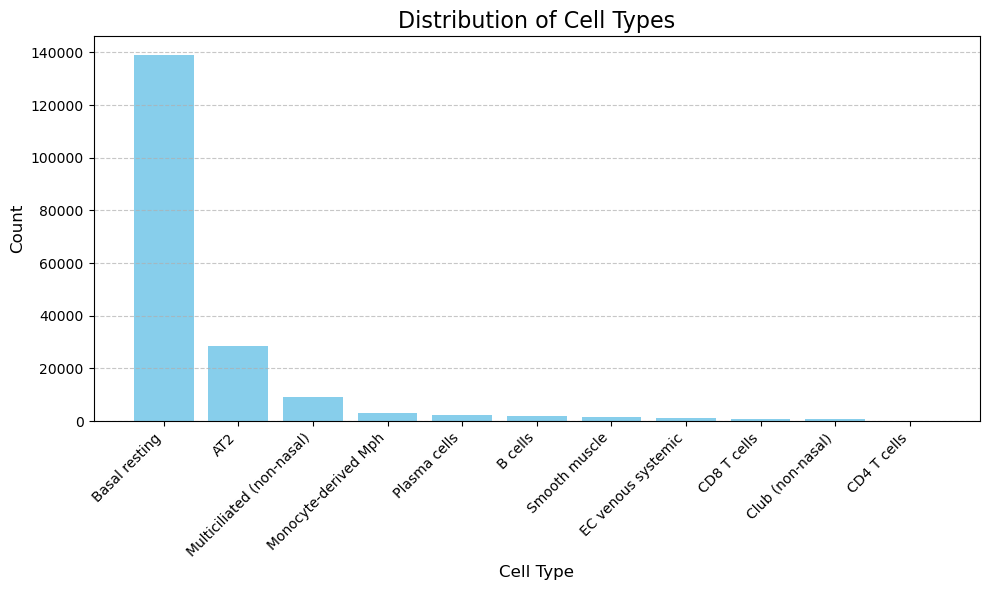

In [22]:
cell_type_counts = adata.obs["M1_majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Results for the  "Cells_Lung_Airway.pkl" model

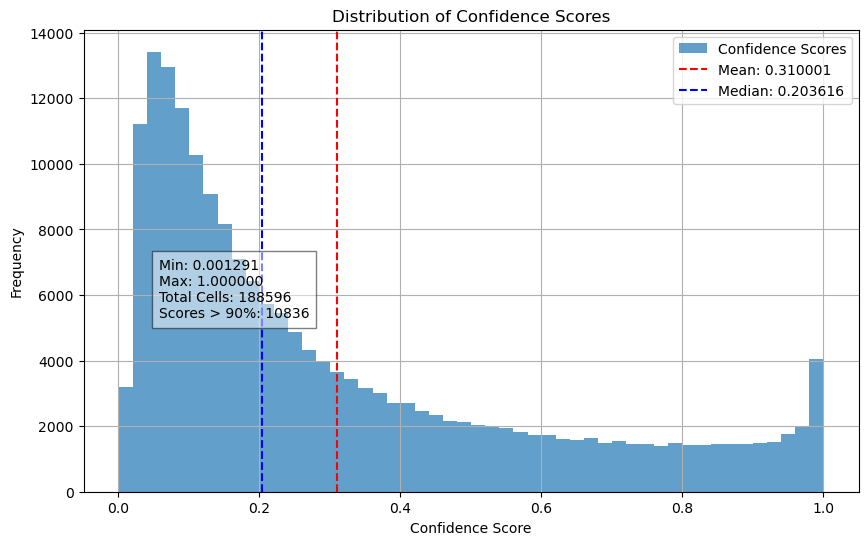

In [17]:
# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['M2_conf_score'].mean()
median_conf_score = adata.obs['M2_conf_score'].median()
total_cells = adata.obs['M2_conf_score'].shape[0]

# Plot histogram
adata.obs['M2_conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['M2_conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['M2_conf_score'].min():.6f}\n"
    f"Max: {adata.obs['M2_conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

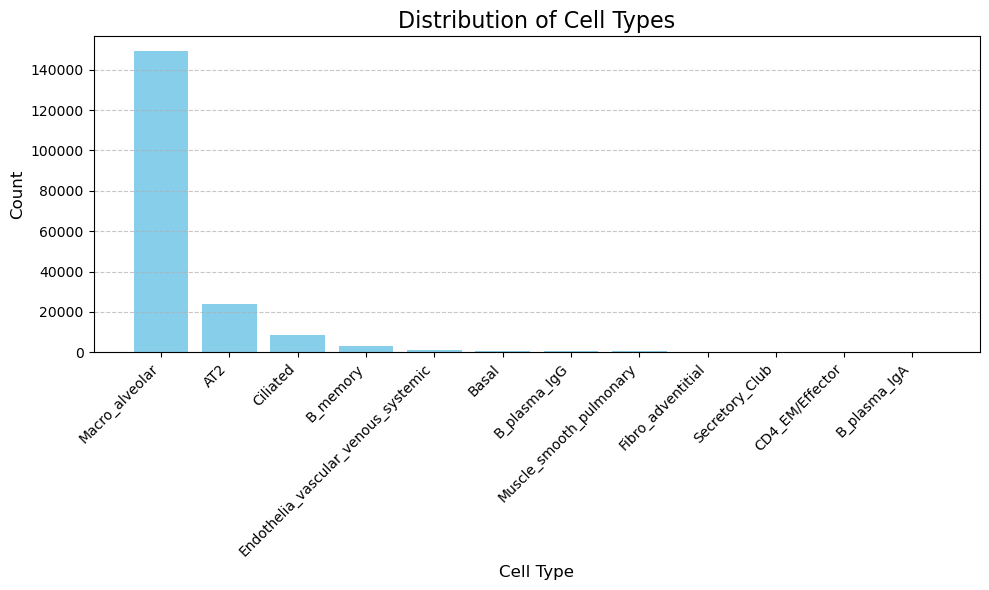

In [23]:
cell_type_counts = adata.obs["M2_majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
cell_type_counts = adata.obs["predicted_labels"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type pred", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type pred"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
predictions2


CellTypist prediction result for 188596 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 188596 query cells and 78 cell types
    probability_matrix: data frame with 188596 query cells and 78 cell types
    adata: AnnData object referred

In [19]:
adata

AnnData object with n_obs × n_vars = 188596 × 18085
    obs: 'cell_type', 'patch_id', 'size_factor', 'lib_size', 'M1_predicted_labels', 'M1_over_clustering', 'M1_majority_voting', 'M1_conf_score', 'M2_predicted_labels', 'M2_over_clustering', 'M2_majority_voting', 'M2_conf_score'
    uns: 'log1p', 'neighbors', 'over_clustering'
    obsm: 'spatial', 'stats', 'X_pca'
    obsp: 'connectivities', 'distances'

## Relation
We compare the two predictions using a dotplot and notice that they do not correspond well to each other.

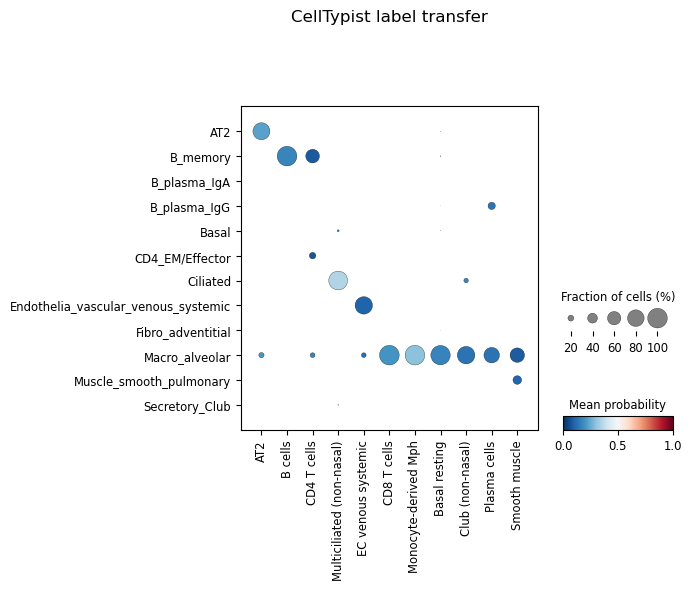

In [24]:
celltypist.dotplot(predictions2, use_as_reference = 'M1_majority_voting', use_as_prediction = 'majority_voting')

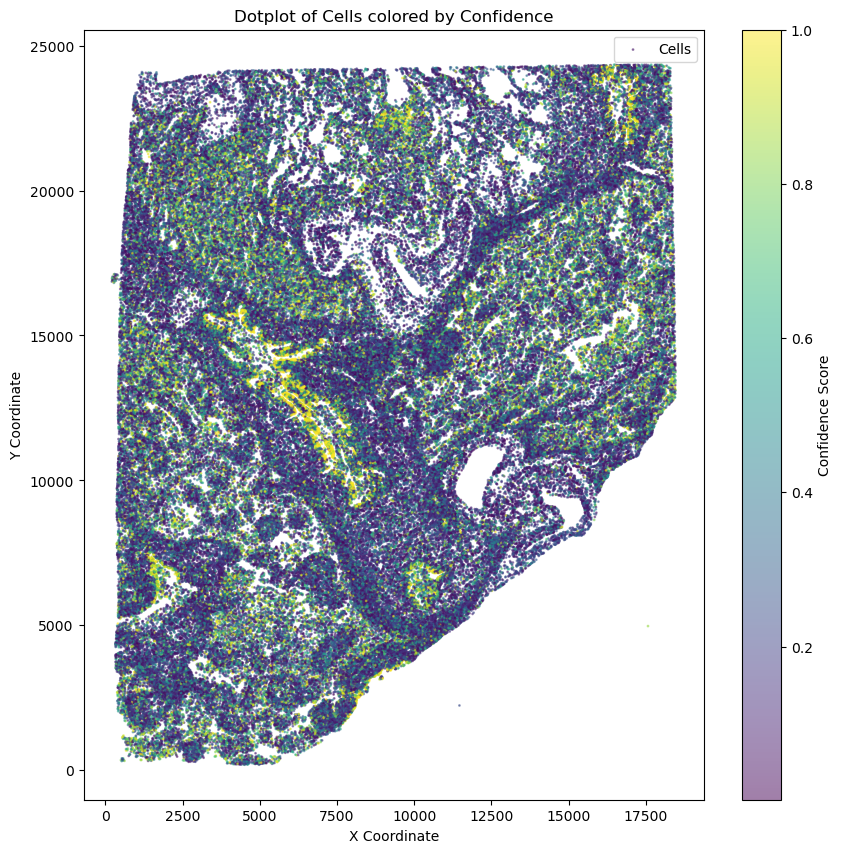

In [25]:

# Create the plot
plt.figure(figsize=(10, 10))
plt.scatter(
    adata.obsm['spatial']['cell_x'],
    adata.obsm['spatial']['cell_y'],
    s=1,
    alpha=0.5,
    c=adata.obs['M2_conf_score'],
    cmap='viridis',
    label='Cells'
)
plt.colorbar(label='Confidence Score')

# Add labels and legend
plt.title('Dotplot of Cells colored by Confidence')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()